In [22]:
include("AZP_env.jl")

score_test (generic function with 1 method)

In [25]:
function ehot(vs::Vector{ComplexF32}, i::Int, s_dim::Int, e_dim::Int)
    ve = zeros(ComplexF32, e_dim*s_dim)
    ve[(e_dim*(i-1)+1):(e_dim*i)] = vs
    return ve
end

function make_ev(e_ev::Matrix{ComplexF32}, s_dim::Int, e_dim::Int)
    e_vec::Vector{Matrix{ComplexF32}} = []
    tot_dim = s_dim * e_dim
    for i in 1:e_dim
        sm = zeros(ComplexF32, tot_dim, s_dim)
        for j in 1:s_dim
            sm[:,j] = ehot(e_ev[:,i], j, e_dim, s_dim)
        end
        push!(e_vec, sm)
    end
    return e_vec
end
function init_dms(s_dim::Int, e_dim::Int, τ::Float32)
    tot_dim = s_dim * e_dim
    s_dm = make_rand_dm(s_dim)
    e_dm = make_rand_dm(e_dim)
    e_es, e_evs = eigen(e_dm)
    #s_es, s_evs = eigen(s_dm)
    U = make_unitary(tot_dim, τ)
    e_evsa = make_ev(e_evs, e_dim, s_dim)
    Ms = make_Mk(U, e_evsa, e_dim, s_dim)
    return DMs(s_dim, e_dim, tot_dim, s_dm, e_dm, e_evs, e_es, U, Ms)
end

init_dms (generic function with 1 method)

In [45]:
env = init_Env_quick(["10", "32", "3", "0.25", "1.0", "256", "1.25", "0.000001"])

KL_loss:5.08052e-5, final_loss:0.00051336084


Env(10, 200, 2, 1, 4, 7, 70, 32, 8, 3, 1000, 200, 500, 1, 1.0f-5, 0.9f0, 512, 0.3f0, 0.25f0, 0.1f0, 1.0f0, 1.0f0, 2, 2, 4, DMs(2, 2, 4, ComplexF32[0.5856222f0 + 0.0f0im 0.35788167f0 + 0.33376303f0im; 0.35788167f0 - 0.33376303f0im 0.41437787f0 + 0.0f0im], ComplexF32[0.39434686f0 + 0.0f0im 0.26751298f0 + 0.23007701f0im; 0.26751298f0 - 0.23007701f0im 0.60565317f0 + 0.0f0im], ComplexF32[0.6081511f0 + 0.523046f0im 0.4527287f0 + 0.38937354f0im; -0.59713906f0 + 0.0f0im 0.80213773f0 + 0.0f0im], Float32[0.13167788, 0.86832213], ComplexF32[0.41143668f0 - 0.33330575f0im -0.6992245f0 - 0.2358353f0im -0.26163015f0 - 0.2771097f0im 0.17138891f0 - 0.021900872f0im; -0.39051878f0 - 0.09309919f0im 0.27575058f0 - 0.4119401f0im -0.7508584f0 - 0.1408502f0im -0.06822322f0 - 0.0693752f0im; -0.2825246f0 - 0.071229324f0im -0.28440297f0 - 0.15972182f0im 0.27180985f0 - 0.21696676f0im -0.80281615f0 - 0.20794529f0im; 0.2130757f0 + 0.6543393f0im -0.07998153f0 + 0.3113529f0im -0.29052517f0 - 0.25646156f0im -0.0613215

In [42]:
function loss_petz(σ_vec::Vector{Float32}, dms::DMs, v2m::Vector{Hermitian{ComplexF32, Matrix{ComplexF32}}})
    σ = vec2dm(σ_vec, v2m)
    K1 = KL_divergence(σ, dms.s_dm)
    K2 = KL_divergence(Λρ(σ, dms), Λρ(dms.s_dm,dms))
    sim_loss = -0.0001f0log(K1+1f-6)
    return (K1-K2)^2 + sim_loss
    #(1.0f0-K2/(K1+1f-6))^2 + sim_loss
end

loss_petz (generic function with 1 method)

In [43]:
σ_vec, lds = Petz_σ(env.dms)
σ = vec2dm(σ_vec, generate_M2(env.dms.s_dim))
println(σ)
println(env.dms.s_dm)
println(KL_divergence(σ, env.dms.s_dm))

ComplexF32[0.54755795f0 + 0.0f0im -0.034221184f0 + 0.35300776f0im; -0.034221184f0 - 0.35300776f0im 0.45244208f0 + 0.0f0im]
ComplexF32[0.5524881f0 + 0.0f0im 0.14867793f0 + 0.36856228f0im; 0.14867793f0 - 0.36856228f0im 0.44751185f0 + 0.0f0im]
0.09698646


In [44]:
using Plots

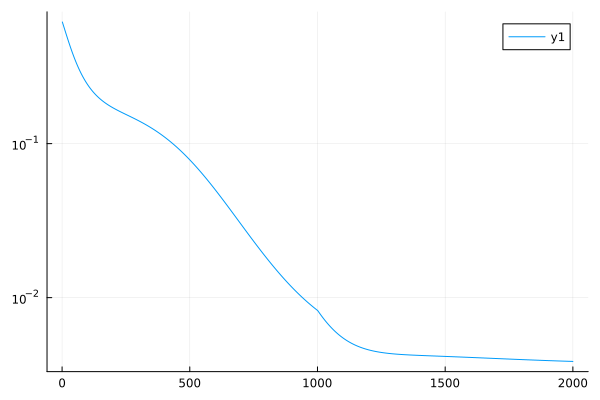

In [34]:
plot(lds, yaxis=:log)

In [46]:
history = [3, 4, 1, 7, 3, 5, 6, 1, 2]
println(hist2eq(history))
println(calc_score(history, env))

UρUd M^{1/2} ρ ΛdUρUd M^{-1/2} Λ ρ Λσ 
0.9074241


In [47]:
history = [7, 3, 5, 6, 5, 5, 5, 1, 2]
println(hist2eq(history))
println(calc_score(history, env))

ΛdUρUd M^{-1/2} Λ M^{-1/2} M^{-1/2} M^{-1/2} ρ Λσ 
0.6024082


In [19]:
lmax_hist = 4
function mhists2matrix(mhists::Vector{Vector{Float32}})
    mat = zeros(Float32, lmax_hist, length(mhists))
    for i in 1:length(mhists)
        if(length(mhists[i]) >= lmax_hist)
            mat[:,i] = mhists[i][1:lmax_hist]
        else
            mat[1:length(mhists[i]),i] = mhists[i]
            mat[length(mhists[i])+1:end,i] .= mhists[i][end]
            mat[length(mhists[i])+1,i] = 10.0f0
        end
    end
    return mat
end

mhists2matrix (generic function with 1 method)

In [20]:
m_hist = [[1.0f0, 2.0f0, 3.0f0],[1.0f0, 5.0f0], [1.0f0, 2.0f0, 3.0f0, 4.0f0, 5.0f0]]

3-element Vector{Vector{Float32}}:
 [1.0, 2.0, 3.0]
 [1.0, 5.0]
 [1.0, 2.0, 3.0, 4.0, 5.0]

In [21]:
mhists2matrix(m_hist)

4×3 Matrix{Float32}:
  1.0   1.0  1.0
  2.0   5.0  2.0
  3.0  10.0  3.0
 10.0   5.0  4.0